In [ ]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet
!{sys.executable} -m pip install torch --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
import torch
from torch.autograd import Variable
import torch.nn as nn

# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

print('Is cuda?', torch.cuda.is_available())

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 3]

Is cuda? True


In [ ]:
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type('torch.cuda.FloatTensor')


torch.manual_seed(3)


Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Define normalisation of voltage channels

Vmax =  max((max(x) for x in dat['V']))
Vmin = min((min(x) for x in dat['V']))
xmax = max(dat['cursorX'])
xmin = min(dat['cursorX'])
ymax = max(dat['cursorY'])
ymin = min(dat['cursorY'])

def Vnormalise(_V):
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

In [ ]:
# Load patient 2
dat = alldat[0, 2]

V = dat['V']
nt, nchan = V.shape
print(nt, nchan)

cx = Xnormalise(dat['cursorX'].flatten())
cy = Ynormalise(dat['cursorY'].flatten())
for c in range(nchan):
    V[:,c] = normalise(V[:,c])

nt, nchan = V.shape

134360 64


In [ ]:
#Define matrix construction
import numpy as np
from sklearn.linear_model import LinearRegression

def hindsight_indices(i, h, l, w):
  indexes = []
  indexes.append(i)
  for window in range(w):
     windowed_index = i - w
     indexes.append(windowed_index) 
  for hindsight in range(h):
    hindsight_index = i - (hindsight+1)*l 
    indexes.append(i - hindsight_index)
    for window in range(w):
     windowed_index = hindsight_index - w
     indexes.append(windowed_index) 
  return indexes

def future_indices(i, f):
  indexes = []
  indexes.append(i)
  for future in range(f):
    future_index = i + (future+1)*40
    indexes.append(future_index)
  return indexes

def construct_matrices (_V, _cx, _cy, _h, _l, _w, _f):
    # Generate feature indices
    i0 = _h*_l+w
    iN = nt - _f*40

    inputs = []
    targets = []

    flip = True
    for i in np.arange(i0, iN, 1, dtype=int):
      hix = hindsight_indices(i, _h, _l, _w)
      fix = future_indices(i, _f)

      hix = list(set(hix))
      fix = list(set(fix))

      input = V[hix,:].flatten()
      inputs.append(input)

      target_x = cx[fix]
      target_y = cy[fix]
      target = [target_x, target_y]
      target = [item for sublist in target for item in sublist]
      targets.append(target)


    regressand = np.array(targets)
    regressor = np.array(inputs)
                
    regressor = torch.from_numpy(regressor)
    regressor = regressor.float()
    regressand = torch.from_numpy(regressand)
    regressand = regressand.float()

    return regressor, regressand

#Define matrix construction
import numpy as np
from sklearn.linear_model import LinearRegression


In [ ]:
def MLP(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    _regressor_train, _regressand_train = construct_matrices(_V_train, _cx_train, _cy_train, _h, _l, normalise=True)
    _regressor_test, _regressand_test = construct_matrices(_V_test, _cx_test, _cy_test, _h, _l, normalise=True)


    _model = LR_fit(_regressor_train, _regressand_train)
    _prediction = LR_predict(_regressor_test, _model)

    return _regressand_test, _prediction

def MLP_fit(regor, regand):
    reg = LinearRegression()
    reg.fit(regor, regand)
    #print('shape:', reg.coef_.shape)
    #print('score:', reg.score(regor, regand))
    return reg

def LR_predict(regor, _model):
    predict = _model.predict(regor[:,:])
    return predict

        


In [ ]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

In [ ]:
h = 0
l = 0
w = 0
f = 2
x, y = construct_matrices(V, cx, cy, h, l, w, f)

x = x.to("cuda")
y = y.to("cuda")

print(x)
print(y)
print(x.shape, y.shape)

tensor([[0.3242, 0.2795, 0.5151,  ..., 0.4915, 0.4192, 0.4490],
        [0.3184, 0.2671, 0.5020,  ..., 0.4800, 0.4060, 0.4463],
        [0.3113, 0.2542, 0.4885,  ..., 0.4690, 0.3950, 0.4438],
        ...,
        [0.5195, 0.5679, 0.5244,  ..., 0.7241, 0.6650, 0.6187],
        [0.5269, 0.5771, 0.5356,  ..., 0.7358, 0.6743, 0.6226],
        [0.5249, 0.5781, 0.5361,  ..., 0.7441, 0.6772, 0.6230]])
tensor([[0.0545, 0.0000, 0.0545, 0.5925, 0.0000, 0.5925],
        [0.0545, 0.0545, 0.0000, 0.5925, 0.5925, 0.0000],
        [0.0545, 0.0000, 0.0545, 0.5925, 0.0000, 0.5925],
        ...,
        [0.3297, 0.3623, 0.3460, 0.8212, 0.8370, 0.8292],
        [0.3460, 0.3297, 0.3623, 0.8292, 0.8212, 0.8370],
        [0.3460, 0.3297, 0.3623, 0.8292, 0.8212, 0.8370]])
torch.Size([134280, 64]) torch.Size([134280, 6])


In [ ]:
boundary = 0.8
no_samples = x.shape[0]

cutoff = int(np.floor(boundary*no_samples))

x_train, x_test = x[:cutoff], x[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

print("number of training samples: {}, number of testing samples: {}".format(x_train.shape[0], x_test.shape[0]))

number of training samples: 107424, number of testing samples: 26856


In [ ]:
model = Feedforward(x_train.shape[1], 100, y_train.shape[1])

loss = torch.nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)


In [ ]:
model.eval()
y_pred_init = model(x_test)
print(y_pred_init.shape)
before_train = loss(y_pred_init.squeeze(), y_test.squeeze())

print('Test loss before training: {}'.format(before_train.item()))

torch.Size([26856, 6])
Test loss before training: 0.31162089109420776


Epoch 0: train lossX: 0.2835145592689514
Test loss after Training: 0.31028133630752563
Epoch 1000: train lossX: 0.23983556032180786
Test loss after Training: 0.23466676473617554
Epoch 2000: train lossX: 0.21225471794605255
Test loss after Training: 0.21807332336902618
Epoch 3000: train lossX: 0.19918516278266907
Test loss after Training: 0.20923453569412231
Epoch 4000: train lossX: 0.18846464157104492
Test loss after Training: 0.19826297461986542
Epoch 5000: train lossX: 0.18154947459697723
Test loss after Training: 0.1906653195619583
Epoch 6000: train lossX: 0.17693698406219482
Test loss after Training: 0.1854381263256073
Epoch 7000: train lossX: 0.17288130521774292
Test loss after Training: 0.1802413910627365
Epoch 8000: train lossX: 0.16920514404773712
Test loss after Training: 0.1757337749004364
Epoch 9000: train lossX: 0.16588522493839264
Test loss after Training: 0.17158164083957672
Epoch 10000: train lossX: 0.16290760040283203
Test loss after Training: 0.16789954900741577
Epoch 

<function matplotlib.pyplot.legend>

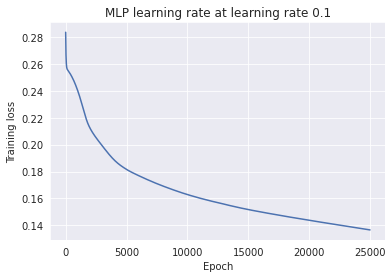

In [ ]:
model.train()
epoch = 25000
L1s = []
test_rms = []
epochs = []
for epoch in range(epoch):
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    #traj_preds = [yX_pred.cpu(), yY_pred.cpu()] 
    #traj_preds = [item for sublist in traj_preds for item in sublist]
    #traj_true_train = [yX_train.cpu(), yY_train.cpu()]
    #traj_true_train = [item for sublist in traj_true_train for item in sublist]
    L1 = loss(y_pred.squeeze(), y_train)


    #L1 regularization (as some channels are known to not be relevant)
    #reg_lambda = 0.001
    #reg_normX = sum(p.abs().sum()
    #              for p in modelX.parameters())
    #L1X = L1X + reg_lambda * reg_normX
    #reg_normY = sum(p.abs().sum()
    #              for p in modelY.parameters())
    #L1Y = L1Y + reg_lambda * reg_normY
    
    
    # Backward pass
    L1.backward()
    optimizer.step()
    L1s.append(L1.item())


    if epoch%1000 == 0:
        print('Epoch {}: train lossX: {}'.format(epoch, L1.item()))

    if epoch%1000 == 0:
        model.eval()
        y_pred = model(x_test)
        after_train = loss(y_pred.squeeze(), y_test) 
        print('Test loss after Training: {}'.format(after_train.item()))
        model.train()
        epochs.append(epoch)
        test_rms.append(after_train.item())


        
        

      
plt.plot(L1s, label='test loss')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("MLP learning rate at learning rate 0.1")
plt.legend



[0.31028133630752563, 0.23466676473617554, 0.21807332336902618, 0.20923453569412231, 0.19826297461986542, 0.1906653195619583, 0.1854381263256073, 0.1802413910627365, 0.1757337749004364, 0.17158164083957672, 0.16789954900741577, 0.16480155289173126, 0.1622036099433899, 0.16002565622329712, 0.15813477337360382, 0.15648341178894043, 0.15512655675411224, 0.15406697988510132, 0.15332244336605072, 0.15277644991874695, 0.1523289978504181, 0.1520034521818161, 0.15180037915706635, 0.15166549384593964, 0.15152743458747864]
[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000]


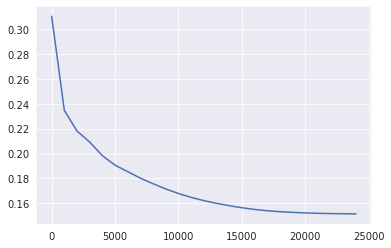

In [ ]:
print(test_rms)
print(epochs)

plt.plot(epochs, test_rms)

In [ ]:
model.eval()
y_pred = model(x_test)

after_train = loss(y_pred.squeeze(), y_test) 
 

print('Test loss after Training: {}'.format(after_train.item()))

Test loss after Training: 0.1513989120721817


In [ ]:
def bin_trajectory(x, y, nbins):
  
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = len(bin_x[0])
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory")
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory", color='#C44E52')

  plt.legend()


def rms(sig1, sig2):
    _diff = sig1 - sig2
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

def MA(signal, window):
    hindsight = []
    signal_smoothed = []
    for i in range(len(signal)):
        hindsight.append(signal[i])
        if len(hindsight) > window:
            hindsight.pop(0)
        signal_smoothed.append(np.mean(hindsight))
    return signal_smoothed

def smooth_prediction(signal, window):
    out = np.zeros_like(signal)
    out[:,0] = MA(signal[:,0], window)
    out[:,1] = MA(signal[:,1], window)
    return out

In [ ]:
yi = int(y.shape[1]/2)

y_extracted_true = y_test[:, [0, yi]]
x_traj_true = y_extracted_true[:,0].tolist()
y_traj_true = y_extracted_true[:,1].tolist()

y_extracted_pred = y_pred[:, [0, yi]]
x_traj_pred = y_extracted_pred[:,0].tolist()
y_traj_pred = y_extracted_pred[:,1].tolist()

In [ ]:
def rms(sig1, sig2):
    _diff = sig1 - sig2
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

In [ ]:
traj_preds = [x_traj_pred, y_traj_pred]
traj_preds = np.array([item for sublist in traj_preds for item in sublist]).flatten()
traj_true = [x_traj_true, y_traj_true]
traj_true = np.array([item for sublist in traj_true for item in sublist]).flatten()
final_rms = rms(traj_preds, traj_true)
print("rms: ", final_rms)




rms:  0.20704544133069033


Text(0.5, 0.98, 'Hindsight = 0, lag = 0, rms = 0.20704544133069033')

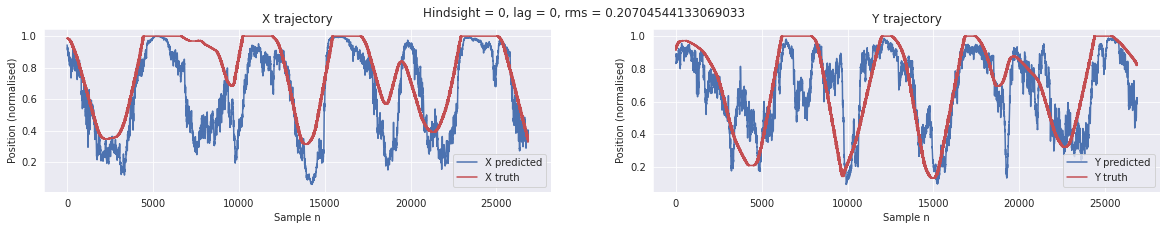

In [ ]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(x_traj_pred, label="X predicted")
plt.plot(x_traj_true, label="X truth", color='#C44E52')
plt.title('X trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_traj_pred, label="Y predicted")
plt.plot(y_traj_true, label="Y truth", color='#C44E52')
plt.title('Y trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.suptitle('Hindsight = {}, lag = {}, rms = {}'.format(h, l, final_rms))






In [ ]:
def bin_trajectory(x, y, nbins):
  
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = len(bin_x[0])
  return bin_traj, binsize

def plot_trajectories(true_x, true_y, preds_x, preds_y, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true_x, true_y, nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds_x, preds_y, nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory")
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory", color='#C44E52')
    plt.xlabel("Normalised x coordinate")
    plt.ylabel("Normalised y coordinate")


1343


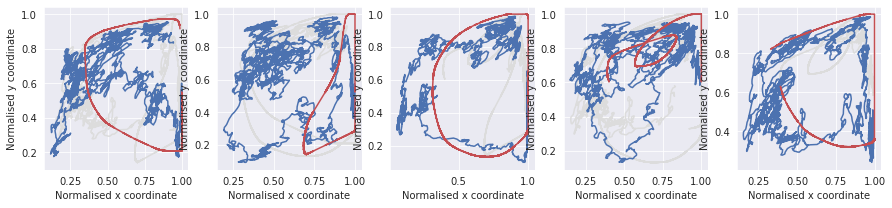

In [ ]:
plot_trajectories(x_traj_true, y_traj_true, x_traj_pred, y_traj_pred, 5, True)


In [ ]:
def MA(signal, window):
    hindsight = []
    signal_smoothed = []
    for i in range(len(signal)):
        hindsight.append(signal[i])
        if len(hindsight) > window:
            hindsight.pop(0)
        signal_smoothed.append(np.mean(hindsight))
    return signal_smoothed
    
def smooth_prediction(signal, window):
    out = np.zeros_like(signal)
    out[:,0] = MA(signal[:,0], window)
    out[:,1] = MA(signal[:,1], window)
    return out
    

31


Text(0, 0.5, 'RMS')

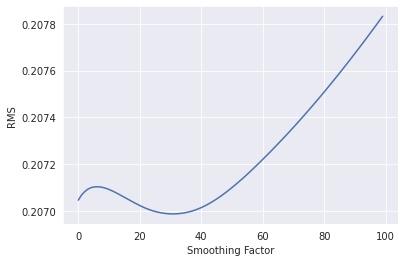

In [ ]:
rmss_smoothing = []
smoothing_values = []
for s in range(100):
  smooth = s+1
  y_traj_pred_smooth = MA(y_traj_pred, smooth)
  x_traj_pred_smooth = MA(x_traj_pred, smooth)

  traj_total = [x_traj_pred_smooth, y_traj_pred_smooth]
  traj_total = [item for sublist in traj_total for item in sublist]

  rmss_smoothing.append(rms(traj_total, traj_true))
  smoothing_values.append(s)

plt.plot(rmss_smoothing)
print(smoothing_values[rmss_smoothing.index(min(rmss_smoothing))])
plt.xlabel("Smoothing Factor")
plt.ylabel("RMS")

0 0 0 2
1343


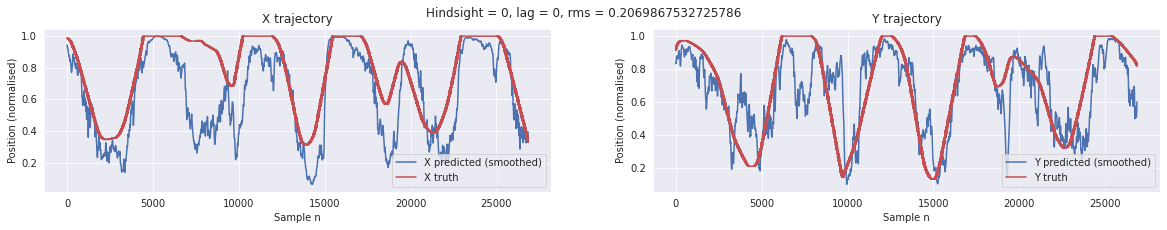

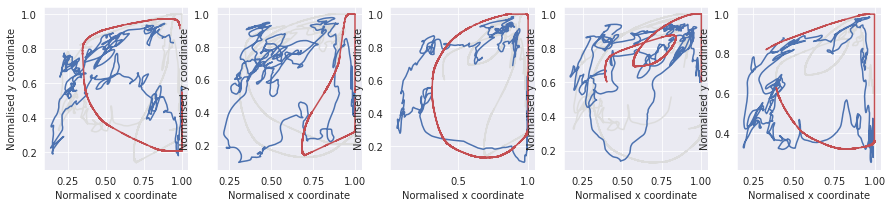

In [ ]:
y_traj_pred_smooth = MA(y_traj_pred, 31)
x_traj_pred_smooth = MA(x_traj_pred, 31)
traj_total = [x_traj_pred_smooth, y_traj_pred_smooth]
traj_total = [item for sublist in traj_total for item in sublist]
rms_smoothed = rms(traj_total, traj_true)

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(x_traj_pred_smooth, label="X predicted (smoothed)")
plt.plot(x_traj_true, label="X truth", color='#C44E52')
plt.title('X trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_traj_pred_smooth, label="Y predicted (smoothed)")
plt.plot(y_traj_true, label="Y truth", color='#C44E52')
plt.title('Y trajectory')
plt.xlabel('Sample n')
plt.ylabel('Position (normalised)')
plt.legend()
plt.suptitle('Hindsight = {}, lag = {}, rms = {}'.format(h, l, rms_smoothed))

print(h, l, w, f)


plot_trajectories(x_traj_true, y_traj_true, x_traj_pred_smooth, y_traj_pred_smooth, 5, True)
